205. Day 2 - Finding Similar Products: Building a RAG Pipeline without LangChain  
8min  

week-08-205-Day-2-Finding-Similar-Products-Building-a-RAG-Pipeline-without-LangChain.md  
week-08-205-Day-2-Finding-Similar-Products-Building-a-RAG-Pipeline-without-LangChain.txt  

## Using Claude for price prediction

## 1. **PIP Installations**


In [1]:
# Install PyTorch and transformers
!pip install torch transformers accelerate huggingface_hub bitsandbytes anthropic

# Install RAPIDS libraries for GPU
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com

# Install ChromaDB and Items
!pip install -q chromadb Items

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


## 2. **GPU and System Checks**

In [2]:
import torch

# Check CUDA version
!nvcc --version

print("="*70)
print("GPU VERIFICATION")
print("="*70)
print(f"CUDA Available: {torch.cuda.is_available()}")
assert torch.cuda.is_available(), "❌ CUDA GPU not found! Change runtime to GPU."

print(f"GPU Device: {torch.cuda.get_device_name(0)}")
print(f"Current Device: {torch.cuda.current_device()}")
print(f"Device Count: {torch.cuda.device_count()}")

gpu_name = torch.cuda.get_device_name(0)
if "L4" not in gpu_name:
    print(f"⚠️ Non-L4 GPU detected: {gpu_name}")
else:
    print(f"✓ Using L4 GPU: {gpu_name}")
print("="*70)

# Set device
device = torch.device('cuda')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
GPU VERIFICATION
CUDA Available: True
GPU Device: NVIDIA L4
Current Device: 0
Device Count: 1
✓ Using L4 GPU: NVIDIA L4


## 3. *Setup Claude API Client**

In [3]:
from google.colab import userdata
import anthropic

# Get API key from Colab secrets
api_key = userdata.get('ANTHROPIC_API_KEY')

# Create Claude client
claude_client = anthropic.Anthropic(api_key=api_key)

print("✓ Claude API client initialized")


✓ Claude API client initialized


## 4. **Mount Google Drive**

In [4]:
from google.colab import drive
import os

# Unmount if already mounted
drive.flush_and_unmount()

# Remount
drive.mount('/content/drive', force_remount=True)

# Navigate to your folder
os.chdir('/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system')

# Get current working directory
print(f"Current directory: {os.getcwd()}")

# List contents
print("\nContents:")
for item in os.listdir('.'):
    print(f"  📁 {item}" if os.path.isdir(item) else f"  📄 {item}")

# Full path example
file_path = os.path.join(os.getcwd(), '202_week8_day2_CUDA-code-chroma_vector_db_advanced_rag_pipeline.ipynb')
print(f"Full path: {file_path}")

Mounted at /content/drive
Current directory: /content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system

Contents:
  📄 Copy of 205_week8_day2_Claude_predict_price_test_RAG_pipeline.ipynb
  📁 agents
  📁 data
  📁 scripts
  📄 130_131_week6_01_buildDatasetAgain.ipynb
  📄 136_week6_01_useThis_buildDatasetAgain.ipynb
  📄 138_week6_day2_convertedOldPickelToNew.ipynb
  📁 products_vectorstore
  📄 202_week8_day2_chroma_vector_db_advanced_rag_pipeline.ipynb
  📄 202_week8_day2_CUDA-code-chroma_vector_db_advanced_rag_pipeline.ipynb
  📄 205_week8_day2_test_RAG_pipeline.ipynb
  📄 205_week8_day2_JustCode_test_RAG_pipeline.ipynb
  📄 test-claude-api.ipynb
Full path: /content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system/202_week8_day2_CUDA-code-chroma_vector_db_advanced_rag_pipeline.ipynb


## 5. **Main Imports**

In [5]:
# ===================================================================
# STEP 1: Standard library imports
# ===================================================================
import sys
import os
import re
import math
import json
import random
from datetime import datetime
import pickle
import time

# ===================================================================
# STEP 2: Third-party imports
# ===================================================================
from tqdm import tqdm
from dotenv import load_dotenv

import torch
from sentence_transformers import SentenceTransformer


import chromadb

from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go

# ===================================================================
# STEP 3: Setup Python path BEFORE importing custom modules
# ===================================================================
base_path = '/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system'

# Change to base directory
os.chdir(base_path)

# Add scripts folder to Python path
scripts_path = os.path.join(base_path, 'scripts')
if scripts_path not in sys.path:
    sys.path.insert(0, scripts_path)

print("="*70)
print("PATH SETUP")
print("="*70)
print(f"Current directory: {os.getcwd()}")
print(f"Scripts path added: {scripts_path}")
print(f"Scripts folder exists: {os.path.exists(scripts_path)}")

# List files in scripts folder to verify
if os.path.exists(scripts_path):
    print("\nFiles in scripts folder:")
    for file in os.listdir(scripts_path):
        print(f"  - {file}")

print("="*70)

# ===================================================================
# STEP 4: NOW import custom modules (after path is configured)
# ===================================================================
try:
    from preprocess_data import Item
    print("✓ Successfully imported Item from preprocess_data")
except ImportError as e:
    print(f"❌ Failed to import Item: {e}")
    # Try alternative import
    try:
        from items import Item
        print("✓ Successfully imported Item from items")
    except ImportError as e2:
        print(f"❌ Failed to import from items too: {e2}")

try:
    from testing import Tester
    print("✓ Successfully imported Tester from testing")
except ImportError as e:
    print(f"❌ Failed to import Tester: {e}")

print("\n✓ All imports configured successfully")

PATH SETUP
Current directory: /content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system
Scripts path added: /content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system/scripts
Scripts folder exists: True

Files in scripts folder:
  - preprocess_data.py
  - __init__.py
  - items.py
  - testing.py
  - __pycache__
  - loaders.py
  - loaders_for_colab.py
  - loaders_for_colab_version_two.py


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

✓ Successfully imported Item from preprocess_data
✓ Successfully imported Tester from testing

✓ All imports configured successfully


## 6. **Copy Dataset to Colab VM**

In [6]:
print("="*70)
print("COPYING DATASET TO LOCAL VM")
print("="*70)

# Define paths
drive_data_folder = "/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system/data/final_v_02"
local_data_folder = "/content/final_data"

# Copy from Drive to local disk for faster access
print(f"Copying from Drive to {local_data_folder}...")
!cp -r "$drive_data_folder" "$local_data_folder"
print("✓ Copy complete")

# Update data_folder variable
data_folder = local_data_folder

# Load pickle files
print("Loading pickle files...")
with open(os.path.join(data_folder, "train.pkl"), 'rb') as file:
    train = pickle.load(file)

with open(os.path.join(data_folder, "test.pkl"), 'rb') as file:
    test = pickle.load(file)

print(f"✓ Loaded train: {len(train):,} items")
print(f"✓ Loaded test: {len(test):,} items")
print("="*70)

COPYING DATASET TO LOCAL VM
Copying from Drive to /content/final_data...
✓ Copy complete
Loading pickle files...
✓ Loaded train: 400,000 items
✓ Loaded test: 26,934 items


## 9. **Copy Vector Database to Colab VM**

In [7]:
print("="*70)
print("COPYING VECTOR DATABASE TO LOCAL VM")
print("="*70)

# Define paths
drive_db_source = "/content/drive/MyDrive/01-LLM-ed-donner/build_multi_agent_system/products_vectorstore"
local_db_path = "/content/products_vectorstore"

# Copy database
print("Copying database from Drive to local disk...")
!cp -r "$drive_db_source" /content/
print("✓ Copy complete")

# Create ChromaDB client
client = chromadb.PersistentClient(path=local_db_path)
collection = client.get_or_create_collection('products')

print(f"✓ ChromaDB connected")
print(f"✓ Collection count: {collection.count():,} items")
print("="*70)

COPYING VECTOR DATABASE TO LOCAL VM
Copying database from Drive to local disk...
✓ Copy complete
✓ ChromaDB connected
✓ Collection count: 400,000 items


## 10. **Load Sentence Transformer Model**

In [8]:
print("="*70)
print("LOADING SENTENCE TRANSFORMER ON GPU")
print("="*70)

# Force GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Loading Sentence Transformer on {device}...")

model_sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2', device=device)

print(f"✓ Sentence Transformer on: {model_sentence_transformer.device}")
print("="*70)

LOADING SENTENCE TRANSFORMER ON GPU
Loading Sentence Transformer on cuda...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Sentence Transformer on: cuda:0


## 11. **Helper Functions**

In [10]:
## 11. **Helper Functions**

def description(item):
    """Extract clean product description from item"""
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split('\n\nPrice is $')[0]


def vector(item):
    """Generate embedding vector for item using Sentence Transformer (GPU optimized)"""
    with torch.no_grad():
        embedding = model_sentence_transformer.encode(
            [description(item)],
            convert_to_tensor=True,
            device='cuda'
        )
    return embedding.cpu().numpy()  # Convert to numpy for ChromaDB


def find_similars(item, n_results=5):
    """Find similar items from ChromaDB vector store"""
    results = collection.query(
        query_embeddings=vector(item).astype(float).tolist(),
        n_results=n_results
    )
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices


def make_context(similars, prices):
    """Format similar items into context string for LLM"""
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message


def get_price(s):
    """Extract numeric price from string"""
    s = s.replace('$', '').replace(',', '')
    match = re.search(r"[-+]?\d*\.?\d+", s)
    return float(match.group()) if match else 0


print("✓ All helper functions defined")

✓ All helper functions defined


## 12. **Test RAG Pipeline**

In [11]:
## 12. **Claude RAG Prediction Function**

def claude_rag(item):
    """
    Use Claude with RAG to predict item price
    """
    # Get similar items from vector DB
    documents, prices = find_similars(item)

    # Build multi-shot prompt with similar items as examples
    user_message = "You are a price estimation expert. Based on similar products, estimate the price of the given item.\n\n"
    user_message += "Here are some similar products with their prices:\n\n"

    # Add each similar item as context
    for i, (doc, price) in enumerate(zip(documents, prices), 1):
        user_message += f"Example {i}:\n{doc}\nPrice: ${price:.2f}\n\n"

    user_message += f"Now estimate the price for this item:\n{description(item)}\n\n"
    user_message += "Respond with ONLY the numeric price value (no dollar sign or other text)."

    # Call Claude API
    message = claude_client.messages.create(
        model="claude-sonnet-4-5-20250929",
        max_tokens=100,
        messages=[
            {"role": "user", "content": user_message}
        ]
    )

    # Extract and parse response
    reply = message.content[0].text.strip()

    return get_price(reply)

print("✓ Claude RAG function defined")

✓ Claude RAG function defined


TESTING CLAUDE RAG PIPELINE
1: Guess: $198.00 Truth: $82.99 Error: $115.01 SLE: 0.74 Item: Sony Dt 55-200mm F4-5.6 SAM SAL55200-2 -...
2: Guess: $79.00 Truth: $140.00 Error: $61.00 SLE: 0.32 Item: BearHoHo Escape Room Props Puzzles Scale...
3: Guess: $88.21 Truth: $91.00 Error: $2.79 SLE: 0.00 Item: Avaya Partner 18D Display Telephone Refu...
4: Guess: $67.99 Truth: $49.99 Error: $18.00 SLE: 0.09 Item: 5J.J3T05.001 Replacement Lamp Special Up...
5: Guess: $2,388.96 Truth: $11.00 Error: $2,377.96 SLE: 28.03 Item: Traxxas 3232X Super Duty Long Glow Plug,...
6: Guess: $65.00 Truth: $65.00 Error: $0.00 SLE: 0.00 Item: Bellroy Phone Case for iPhone 13 Pro wit...
7: Guess: $24.99 Truth: $136.15 Error: $111.16 SLE: 2.77 Item: Big Horn 19505 Preppin Weapon Kit - 5 As...
8: Guess: $11.99 Truth: $11.99 Error: $0.00 SLE: 0.00 Item: Evil Eye Popsocket for Phone Evil Eye Po...
9: Guess: $24.99 Truth: $25.99 Error: $1.00 SLE: 0.00 Item: 12 Pieces Mini Stuffed Forest Animals Ju...
10: Guess: $349.99 

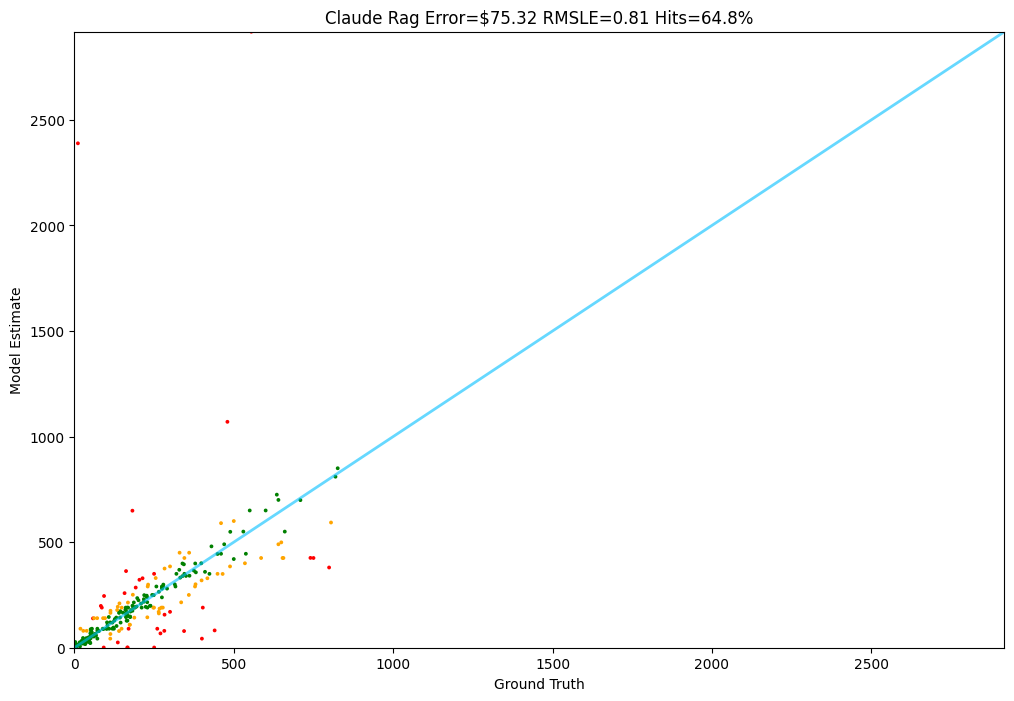


⏱️ Processing time: 586.12 seconds
⏱️ Time per item: 0.02 seconds


In [12]:
## 13. **Test Claude RAG Pipeline**

print("="*70)
print("TESTING CLAUDE RAG PIPELINE")
print("="*70)

start_time = time.time()
Tester.test(claude_rag, test)
end_time = time.time()

total_time = end_time - start_time
print(f"\n⏱️ Processing time: {total_time:.2f} seconds")
print(f"⏱️ Time per item: {total_time / len(test):.2f} seconds")
print("="*70)